# Convolutional Neural Network

In [1]:
from pathlib import Path
from itertools import chain

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from picograd import Module, Linear, Conv2d, max_pool2d, relu, flatten, log_softmax, nll_loss, bce_with_logits_loss, AdamW, train

## MNIST

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

mnist = datasets.fetch_openml(name='mnist_784')

X = mnist.data.to_numpy().astype(np.float64).reshape(-1, 1, 28, 28) / 255.
y = mnist.target.to_numpy().astype(np.int32)

train_X, test_X, train_y, test_y = train_test_split(
    X, y, train_size=10000, test_size=10000, shuffle=False)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((10000, 1, 28, 28), (10000, 1, 28, 28), (10000,), (10000,))

In [3]:
class MNIST(Module):
    def __init__(self):
        self.conv2d_1 = Conv2d(1, 8, kernel_size=3)
        self.conv2d_2 = Conv2d(8, 16, kernel_size=3)
        self.fc1 = Linear(16 * 5 * 5, 100)
        self.fc2 = Linear(100, 10)

    def __call__(self, x):
        x = self.conv2d_1(x)  # 8x26x26
        x = relu(x)
        x = max_pool2d(x, kernel_size=2)  # 8x13x13
        x = self.conv2d_2(x)  # 16x11x11
        x = relu(x)
        x = max_pool2d(x, kernel_size=2)  # 16x5x5
        x = flatten(x)
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return log_softmax(x)

np.random.seed(0)
acc = lambda y_pred, y: np.mean(np.argmax(y_pred.view(np.ndarray), axis=1) == y.view(np.ndarray))
model = MNIST()
optim = AdamW(model.parameters(), lr=0.01)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Val iter:   0%|          | 0/157 [00:00<?, ?it/s]

Iter:   0%|          | 0/157 [00:00<?, ?it/s]

Total epochs = 10 | elapsed = 674.09s | train loss = 0.06081973756862036 | train acc = 0.979893337377414 | val loss = 0.22473411076615388 | val acc = 0.9474095768880795


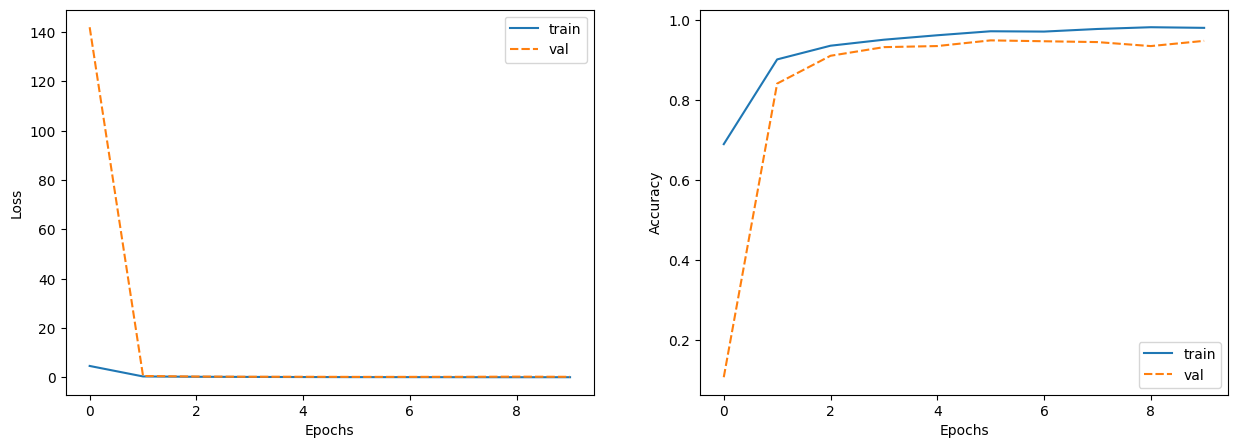

In [4]:
train_kwargs = dict(
    batch_size=64,
    max_epochs=10,
    log_iters=10,
    early_stopping_delta=1e-3,
    early_stopping_patience=3)
train(model, train_X, train_y, nll_loss, acc, optim, X_val=test_X, y_val=test_y, **train_kwargs)

## Not hot dog

![not hot dog](https://miro.medium.com/v2/resize:fit:1300/format:webp/1*VrpXE1hE4rO1roK0laOd7g.png)

In [5]:
BASE_DIR = Path('datasets/hot_dog')
hot_dog_paths = list((BASE_DIR / 'train/hot_dog').glob('*.jpg'))
not_hot_dog_paths = list((BASE_DIR / 'train/not_hot_dog').glob('*.jpg'))
test_hot_dog_paths = list((BASE_DIR / 'test/hot_dog').glob('*.jpg'))
test_not_hot_dog_paths = list((BASE_DIR / 'test/not_hot_dog').glob('*.jpg'))
len(hot_dog_paths), len(not_hot_dog_paths), len(test_hot_dog_paths), len(test_not_hot_dog_paths)

(249, 249, 250, 250)

## Preprocess image

1. Convert RGB to grayscale
2. Center crop to 100px by 100px
3. Convert to fp16 numpy array
4. Normalize to \[0, 1\]

In [6]:
SIZE = 150

def preprocess_image(path, to_np=True):
    img = Image.open(path)
    # img = img.convert('L')
    w, h = img.size
    s = min(w, h)
    crop = (w - s) / 2, (h - s) / 2, (w + s) / 2, (h + s) / 2
    img = img.resize((SIZE, SIZE), box=crop)
    if to_np:
        return np.array(img).transpose((2, 0, 1)) / 255.
    return img

def load(hot_dog_paths, not_hot_dog_paths):
    n = len(hot_dog_paths) + len(not_hot_dog_paths)
    y = np.zeros((n, 1), dtype=np.float32)
    y[:len(hot_dog_paths)] = 1

    X = np.empty((n, 3, SIZE, SIZE), dtype=np.float32)
    for i, path in enumerate(chain(hot_dog_paths, not_hot_dog_paths)):
        X[i, ...] = preprocess_image(path)

    p = np.random.permutation(n)
    return X[p], y[p]

train_X, train_y = load(hot_dog_paths, not_hot_dog_paths)
test_X, test_y = load(test_hot_dog_paths, test_not_hot_dog_paths)

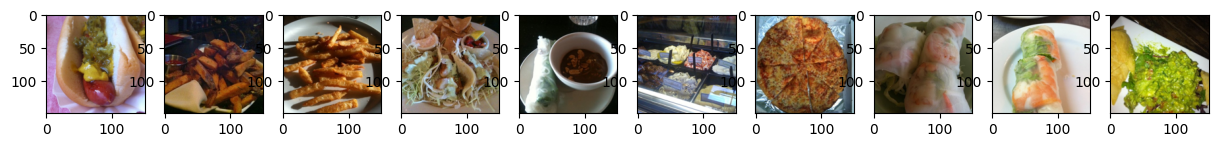

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    ax[i].imshow(train_X[i].transpose((1, 2, 0)))

In [ ]:
class SeeFood(Module):
    def __init__(self):
        self.conv2d_1 = Conv2d(3, 8, kernel_size=3)
        self.conv2d_2 = Conv2d(8, 16, kernel_size=3)
        self.conv2d_3 = Conv2d(16, 32, kernel_size=3)
        self.fc1 = Linear(32 * 17 * 17, 100)
        self.fc2 = Linear(100, 1)

    def __call__(self, x):
        x = self.conv2d_1(x) # 8x148x148
        x = relu(x)
        x = max_pool2d(x, kernel_size=2) # 8x74x74
        x = self.conv2d_2(x) # 16x72x72
        x = relu(x)
        x = max_pool2d(x, kernel_size=2) # 16x36x36
        x = self.conv2d_3(x) # 32x34x34
        x = relu(x)
        x = max_pool2d(x, kernel_size=2) # 32x17x17
        x = flatten(x)
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x

np.random.seed(0)
model1 = SeeFood()
acc1 = lambda y_pred, y: np.mean((y_pred.view(np.ndarray) > 0) == y.view(np.ndarray))
optim1 = AdamW(model1.parameters(), lr=0.001)

In [ ]:
train_kwargs = dict(
    batch_size=16,
    max_epochs=5,
    log_iters=10,
    early_stopping_delta=1e-3,
    early_stopping_patience=3)
train(model1, train_X, train_y, bce_with_logits_loss, acc1, optim1,
      #X_val=test_X[:50], y_val=test_y[:50],
      **train_kwargs)